Import libraries


In [1]:
import csv
#from optparse import OptionParser
from matplotlib import pyplot as plt
import numpy as np
from random import random
import pandas as pd
from numpy.linalg import pinv
from numpy.linalg import inv


Set hyper-parameters for the dataset

In [2]:
numLags = 100
predictionStep = 5


Read Data

In [3]:
df = pd.read_csv('C:/Users/subha/OneDrive/Desktop/Project/data/f10.7cm_radio_flux_data.csv')
df.head(5)

,yy,mm,dd,F10.7
0,1957,10,1,269.8
1,1957,10,2,253.6
2,1957,10,3,266.4
3,1957,10,4,238.2
4,1957,10,5,246.0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23973 entries, 0 to 23972
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yy      23973 non-null  int64  
 1   mm      23973 non-null  int64  
 2   dd      23973 non-null  int64  
 3   F10.7   23973 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 749.3 KB


In [5]:
df.isnull().sum()

yy       0
mm       0
dd       0
F10.7    0
dtype: int64

standardize data by subtracting mean and dividing by std

In [6]:
meanSeq = np.mean(df['F10.7'])
stdSeq = np.std(df['F10.7'])
df['F10.7'] = (df['F10.7'] - meanSeq)/stdSeq


In [7]:
df.head()

,yy,mm,dd,F10.7
0,1957,10,1,2.859606
1,1957,10,2,2.548316
2,1957,10,3,2.794273
3,1957,10,4,2.252399
4,1957,10,5,2.402279


Prepare input-target pairs

In [8]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['F10.7'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['F10.7'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep)

generate time embedded matrix


input shape:  (23973, 100)
target shape:  (23973, 1)


In [9]:
print(X.shape, T.shape)

(23973, 100) (23973, 1)


Online Sequential Extreme Learning Machine (OS-ELM)
Base operation: linear layer with nonlinear activation using NumPy


In [10]:
weights = np.random.random((20,100))
print('weights:',weights.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

def linear(features,weights,bias):
   return np.dot(features, np.transpose(weights)) + bias

hidden = linear(features,weights,bias)
print('hidden (before nonlinear activation):', hidden.shape)

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))

hidden = sigmoidActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)

def reluActFunc(features):
  return np.maximum(0,features)
hidden = reluActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)


weights: (20, 100)
bias: (1, 20)
input features: (1, 100)
hidden (before nonlinear activation): (1, 20)
hidden (after nonlinear activateion): (1, 20)
hidden (after nonlinear activateion): (1, 20)


Set model hyper-parameters


In [11]:
nDimInput = 100
nDimOutput = 1
numNeurons = 25
lamb=0.0001
outputWeightFF = 0.92 

OSELM implementation

In [12]:
class OSELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
    self.name = 'OSELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights = None
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None
    # auxiliary matrix used for sequential learning
    self.M = None

    self.forgettingFactor = forgettingFactor

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """
    V = linear(features, self.inputWeights,self.bias)
    #H = sigmoidActFunc(V)
    H = reluActFunc(V)
    return H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    """
    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    # auxiliary matrix used for sequential learning
    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    # hidden to output layer connection
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])



  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)


    self.M = (1/self.forgettingFactor) * self.M - np.dot((1/self.forgettingFactor) * self.M,
                                     np.dot(Ht, np.dot(
                                       pinv(np.eye(numSamples) + np.dot(H, np.dot((1/self.forgettingFactor) * self.M, Ht))),
                                       np.dot(H, (1/self.forgettingFactor) * self.M))))
    self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction

In [13]:
net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
net.initializePhase(lamb=lamb)

Online learning and prediction of OS-ELM


In [14]:
predictions= []
target= []

for i in range(numLags, len(df)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])

    print ("{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1]))
     

  100th timeStep -  target:   3.7378   |    prediction:   3.8126 
  101th timeStep -  target:   3.5014   |    prediction:   3.5675 
  102th timeStep -  target:   3.2766   |    prediction:   3.2498 
  103th timeStep -  target:   3.0498   |    prediction:   2.7299 
  104th timeStep -  target:   2.5791   |    prediction:   2.4596 
  105th timeStep -  target:   2.1659   |    prediction:   1.6918 
  106th timeStep -  target:   2.4119   |    prediction:   2.6279 
  107th timeStep -  target:   2.1851   |    prediction:   2.4265 
  108th timeStep -  target:   1.9507   |    prediction:   1.7182 
  109th timeStep -  target:   1.6317   |    prediction:   2.0580 
  110th timeStep -  target:   1.6510   |    prediction:   1.9573 
  111th timeStep -  target:   1.5587   |    prediction:   2.0585 
  112th timeStep -  target:   1.8220   |    prediction:   2.7810 
  113th timeStep -  target:   1.4473   |    prediction:  -0.0155 
  114th timeStep -  target:   1.2417   |    prediction:   1.0221 
  115th ti

  640th timeStep -  target:   1.3493   |    prediction:   1.5257 
  641th timeStep -  target:   1.3493   |    prediction:   1.3442 
  642th timeStep -  target:   1.6682   |    prediction:   2.0561 
  643th timeStep -  target:   1.5280   |    prediction:   2.1184 
  644th timeStep -  target:   2.3216   |    prediction:   2.1266 
  645th timeStep -  target:   2.5003   |    prediction:   2.5211 
  646th timeStep -  target:   2.9173   |    prediction:   1.8772 
  647th timeStep -  target:   2.5387   |    prediction:   1.3628 
  648th timeStep -  target:   2.8558   |    prediction:   2.6885 
  649th timeStep -  target:   2.4388   |    prediction:   2.2378 
  650th timeStep -  target:   2.2601   |    prediction:   2.7219 
  651th timeStep -  target:   2.0795   |    prediction:   1.3994 
  652th timeStep -  target:   1.8028   |    prediction:   2.2142 
  653th timeStep -  target:   1.4242   |    prediction:   1.3604 
  654th timeStep -  target:   1.2052   |    prediction:   1.5591 
  655th ti

Evaluation: Calculate total Normalized Root Mean Square Error (NRMSE)

In [15]:
 #Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))


NRMSE nan


C:\Users\subha\AppData\Local\Temp\ipykernel_24208\291633081.py:8: RuntimeWarning: overflow encountered in square
  squareDeviation = np.square(predictions-truth)
C:\Users\subha\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1745: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)
C:\Users\subha\AppData\Local\Temp\ipykernel_24208\291633081.py:15: RuntimeWarning: invalid value encountered in double_scalars
  nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)


Plot predictions and target values

NameError: name 'dataSet' is not defined

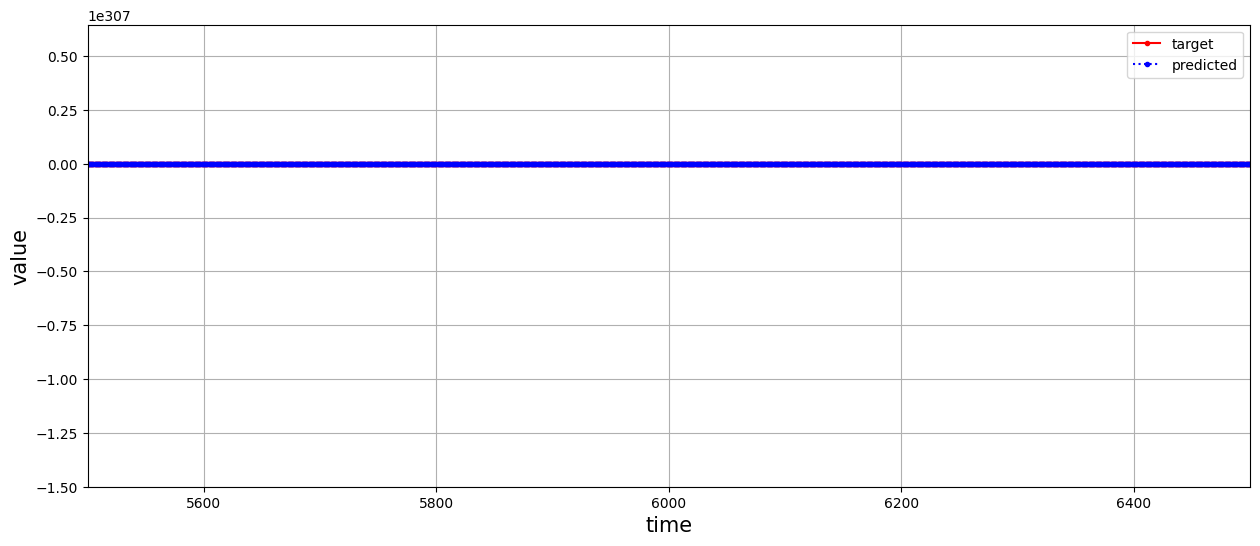

In [16]:
algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([5500,6500])
#plt.ylim([0, 30000])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)